In [26]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.impute import KNNImputer

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.optimizers import Adam 
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
from collections import Counter

# Load data
data = pd.read_csv("data/reduced_sax_presnap.csv")

data = data.dropna(subset = "playOutcome")

# Preprocess Time and Drop Unused Columns
data["hour"] = pd.to_datetime(data["time"]).dt.hour
data = data.drop(columns=["position", "time"])

# Encode playOutcome using LabelEncoder
label_encoder = LabelEncoder()
data['playOutcome_encoded'] = label_encoder.fit_transform(data['playOutcome'])


# Convert all boolean columns to integers
bool_cols = data.select_dtypes(include=['bool']).columns
data[bool_cols] = data[bool_cols].astype(int)

# Preprocess SAX Columns
sax_columns = ['sax_X_std', 'sax_Y_std', 'sax_a', 'sax_s', 'sax_o', 'sax_dir']
max_length = max(len(seq) for col in sax_columns for seq in data[col])

# Step 1: Preprocess SAX Columns
char_to_int = {}
for column in sax_columns:
    for char in ''.join(data[column].values):
        if char not in char_to_int:
            char_to_int[char] = len(char_to_int) + 1

def one_hot_encode_sax(data, sax_columns, max_positions, char_to_int):
    for col in sax_columns:
        for pos in range(max_positions):
            data[f"{col}_pos_{pos+1}"] = data[col].apply(
                lambda seq: char_to_int.get(seq[pos], 0)
            )

    # Create one-hot encoded columns for each position and character
    for col in sax_columns:
        for pos in range(max_positions):
            for char in char_to_int.keys():
                data[f"{col}_pos_{pos+1}_{char}"] = data[f"{col}_pos_{pos+1}"].apply(
                    lambda x: 1 if x == char_to_int[char] else 0
                )

    # Drop the original integer-encoded columns
    data.drop(columns=[f"{col}_pos_{pos+1}" for col in sax_columns for pos in range(max_positions)], inplace=True)

# Apply one-hot encoding to your DataFrame
one_hot_encode_sax(data, sax_columns, max_length, char_to_int)

data = data.drop(columns = sax_columns)
data = data.drop(columns=["playOutcome", "Unnamed: 0", "yardlineSide", "qbSneak"]) # drop columns we don't need anymore

# Preprocess Additional Features
numeric_features = [
    "hour", "week", "quarter", "down", "yardsToGo", "yardlineNumber",
    "gameClock_min", "gameClock_sec", "preSnapHomeScore", "preSnapVisitorScore",
    "absoluteYardlineNumber", "preSnapHomeTeamWinProbability", "expectedPoints",
    "weight", "age", "time_diff", "distance", "height_inches"
]

for feature in numeric_features:
    if feature in data.columns:
        data[feature] = pd.to_numeric(data[feature], errors='coerce')
        data[feature] = (data[feature] - data[feature].mean()) / data[feature].std()


categorical_features = list(set(data.columns) - set(numeric_features + ['playOutcome_encoded']))
categorical_data = pd.get_dummies(data[categorical_features]).values


categorical_features = list(set(data.columns) - set(numeric_features + ['playOutcome_encoded']))
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le

# Combine numeric and categorical features
combined_features = numeric_features + categorical_features
combined_data = data[combined_features]

# Apply KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)
imputed_data = knn_imputer.fit_transform(combined_data)

# Convert imputed data back to a DataFrame
imputed_data = pd.DataFrame(imputed_data, columns=combined_features)

# Decode categorical features back to original categories (if necessary)
for col in categorical_features:
    imputed_data[col] = imputed_data[col].round().astype(int)  # Ensure integer encoding
    imputed_data[col] = label_encoders[col].inverse_transform(imputed_data[col])

# Separate numeric and categorical data after imputation
numeric_data = imputed_data[numeric_features].values

# One-hot encode categorical data
categorical_data = pd.get_dummies(imputed_data[categorical_features]).values

# Prepare features and labels
X = np.hstack([numeric_data, categorical_data])
y = data['playOutcome_encoded'].values
num_classes = len(np.unique(y))

majority_class_size = max(Counter(y).values())
scaling_factor = 0.3  # percentage of majority class
sampling_strategy = {
    cls: max(count, int(majority_class_size * scaling_factor))  # Ensure no class is reduced
    for cls, count in Counter(y).items()
}

# Ensure k_neighbors is valid
smallest_class_size = min(Counter(y).values())
k_neighbors = max(1, min(5, smallest_class_size - 1))

# Apply SMOTE with corrected strategy
smote = SMOTE(random_state=42, k_neighbors=k_neighbors, sampling_strategy=sampling_strategy)
X, y = smote.fit_resample(X, y)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify = y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=1
)


# Define the parameter grid for the SVM
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel types
    'gamma': ['scale', 'auto']  # Kernel coefficient
}

test_error = []

for iteration in range(10):

# Initialize the SVM model
    svm = SVC(kernel='rbf', C=1, gamma='scale', class_weight='balanced', random_state=42)

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Display the best parameters
    print(f"Best parameters: {grid_search.best_params_}")

    # Evaluate on the validation set
    best_svm = grid_search.best_estimator_
    y_val_pred = best_svm.predict(X_val)

    # Print classification report
    print("Validation Classification Report:")
    print(classification_report(y_val, y_val_pred))

    # Evaluate on the test set
    y_test_pred = best_svm.predict(X_test)

    test_accuracy = accuracy_score(y_test, y_pred)
    test_error.append(test_accuracy)


/var/folders/gs/rvxrkqns1ws3722g5ty7jpqw0000gn/T/ipykernel_8435/1051005666.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{col}_pos_{pos+1}"] = data[col].apply(
/var/folders/gs/rvxrkqns1ws3722g5ty7jpqw0000gn/T/ipykernel_8435/1051005666.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{col}_pos_{pos+1}"] = data[col].apply(
/var/folders/gs/rvxrkqns1ws3722g5ty7jpqw0000gn/T/ipykernel_8435/1051005666.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert

Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       0.88      1.00      0.93        14
           2       0.83      0.88      0.86        17
           3       0.33      0.18      0.23        17
           4       0.56      0.58      0.57        33
           5       0.54      0.35      0.42        20
           6       0.93      0.68      0.79        19
           7       0.80      0.80      0.80        10
           8       0.73      0.73      0.73        11
           9       0.66      0.80      0.73        46
          10       0.79      0.88      0.83        17
          11       0.78      0.93      0.85        15
          12       1.00      1.00      1.00        14

    accuracy                           0.73       242
   macro avg       0.75      0.76      0.74       242
weighted avg       0.71      0.73     

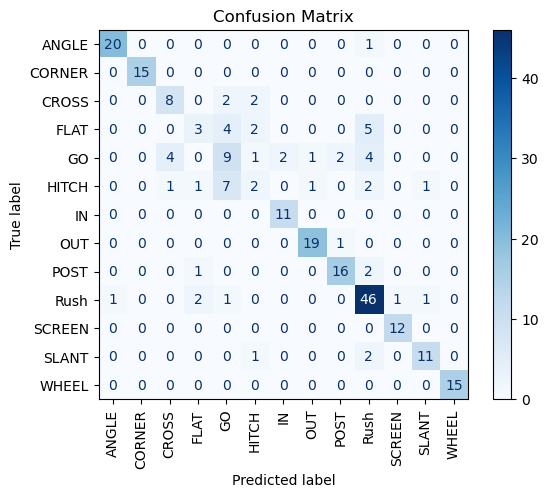

In [17]:
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

y_pred = best_svm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=label_encoder.classes_
)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xticks(rotation = 90)
plt.show()

In [10]:
print(f"Number of NaN values in X: {np.isnan(X).sum()}")

Number of NaN values in X: 0


In [11]:
data["playOutcome_encoded"].unique()

array([ 9,  3,  2, 10,  4,  0,  5, 11,  7,  8,  6,  1, 12])

In [12]:
df = pd.read_csv("data/reduced_sax_presnap.csv")

In [13]:
df = df["playOutcome"].dropna()

In [14]:
len(df)

1097

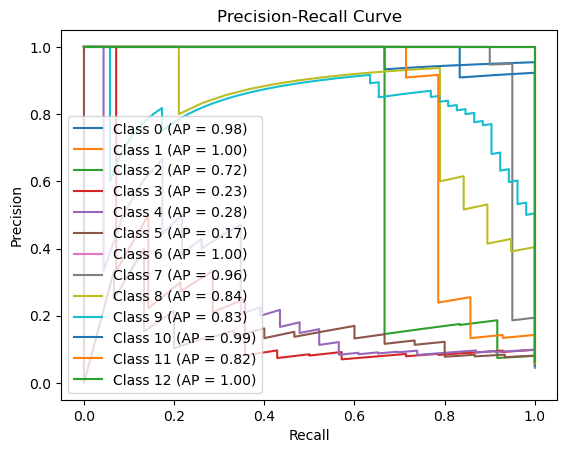

In [19]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

y_pred_prob = best_svm.decision_function(X_test)  # For SVMs, use decision_function

for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_prob[:, i])
    avg_precision = average_precision_score(y_test_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, label=f'Class {i} (AP = {avg_precision:.2f})')

plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.show()


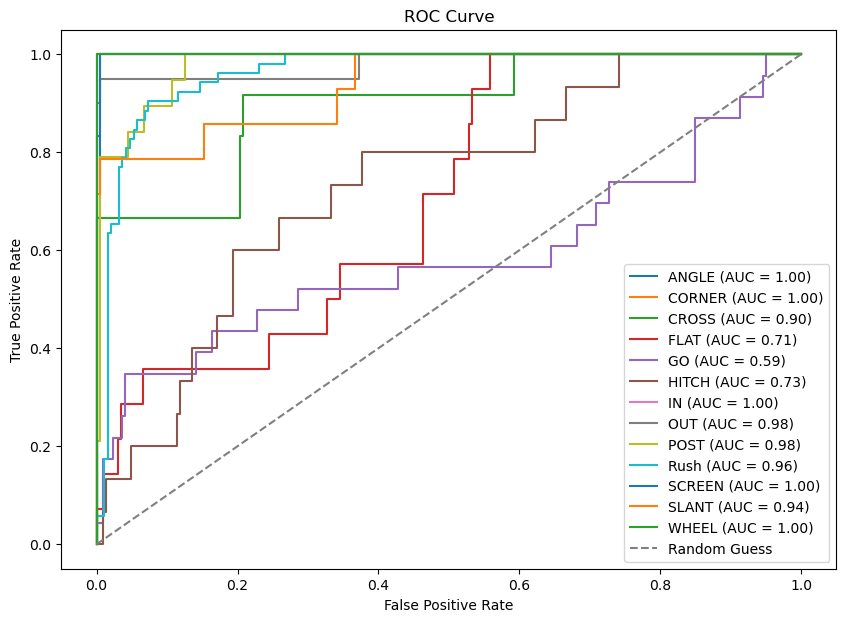

In [22]:
original_labels = label_encoder.inverse_transform(np.unique(y_test))  # Get original label names

plt.figure(figsize=(10, 7))
for i, label_name in enumerate(original_labels):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="best")
plt.show()

In [24]:
tracking = pd.read_csv("data/all_tracking_nfc_south.csv")

In [28]:
sum(data["playOutcome_encoded"].value_counts())

1097

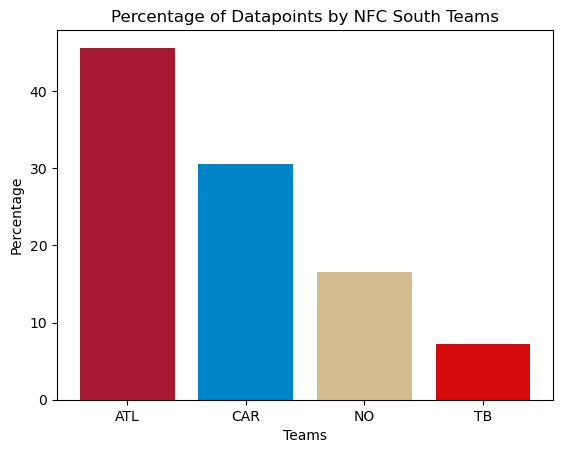

In [40]:

teams = ["ATL", "CAR", "NO", "TB"]
scores = [45.6, 30.5, 16.6, 7.2]

team_colors = {
    "ATL": "#A71930",  # Atlanta Falcons Red
    "CAR": "#0085CA",  # Carolina Panthers Blue
    "NO": "#D3BC8D",   # New Orleans Saints Gold
    "TB": "#D50A0A"    # Tampa Bay Buccaneers Red
}

# Extract the colors for the given teams
colors = [team_colors[team] for team in teams]

# Create the bar chart
plt.bar(teams, scores, color=colors)

# Add labels and title
plt.xlabel("Teams")
plt.ylabel("Percentage")
plt.title("Percentage of Datapoints by NFC South Teams")

# Display the plot
plt.show()

In [34]:
data = pd.read_csv("data/red")

data["possessionTeam_TB"].sum()

0

In [36]:
data["possessionTeam_CAR"].sum()

564

In [37]:
data["possessionTeam_NO"].sum()

158

In [38]:
data["possessionTeam_ATL"].sum()

375